# Прочит на набора от данни

Започваме като зареждаме набораот данни. Всеки запис съдържа характеристики на кафета като: вид, производител, ниво на влажност, дали е добро качество и др. Характеристиките са от най-различни типове данни. Например  нивота на влажност е представена като десетично число (double), а вида кафе е преставен, като категория. Също така има непълни записи, от които липсват данни. Полетата, за които липсват данни просто са празни.

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

file_path = '/content/drive/MyDrive/train_data.csv'
data = pd.read_csv(file_path)
print(data.shape)

(1339, 34)


Виждаме, че набора от данни включва 1339 записа с по 34 характеристики.

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1339 entries, 0 to 1338
Data columns (total 34 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Id                     1339 non-null   int64  
 1   Species                1339 non-null   object 
 2   Owner                  1332 non-null   object 
 3   Country.of.Origin      1338 non-null   object 
 4   Farm.Name              980 non-null    object 
 5   Lot.Number             276 non-null    object 
 6   Mill                   1021 non-null   object 
 7   ICO.Number             1180 non-null   object 
 8   Company                1130 non-null   object 
 9   Altitude               1113 non-null   object 
 10  Region                 1280 non-null   object 
 11  Producer               1107 non-null   object 
 12  Number.of.Bags         1339 non-null   int64  
 13  Bag.Weight             1339 non-null   object 
 14  In.Country.Partner     1339 non-null   object 
 15  Harv

Информация за данните

# Обработка на  данните

### Свързаност на  данните

### Ще премахнем колоните с много липсващи данни и тези, чиято информация е маловажна и нерелевантна за нас.

In [33]:
columns_to_drop = ['Farm.Name', 'Lot.Number', 'Mill', 'ICO.Number', 'Company',
                   'Owner.1', 'altitude_low_meters', 'altitude_high_meters',
                   'altitude_mean_meters', 'Certification.Body', 'Certification.Address',
                   'Certification.Contact', 'unit_of_measurement']
data_cleaned = data.drop(columns=columns_to_drop)

### Запълване на липсващите стоиности.

Все още в набора данни има празни полета, затова за категориалните променливи (категории) запълваме липсващите стойности с модалната стойност (най-честата стойност). За числовите променливи запълваме липсващите стойности с медианата.

In [34]:
categorical_columns = data_cleaned.select_dtypes(include=['object']).columns
numerical_columns = data_cleaned.select_dtypes(exclude=['object']).columns

for column in categorical_columns:
    data_cleaned[column].fillna(data_cleaned[column].mode()[0], inplace=True)
for column in numerical_columns:
    data_cleaned[column].fillna(data_cleaned[column].median(), inplace=True)

categorical_columns = data_cleaned.select_dtypes(include=['object']).columns
print("Категориални променливи:", categorical_columns)
categorical_columns = categorical_columns.drop('Good.Quality.Coffee', errors='ignore')

Категориални променливи: Index(['Species', 'Owner', 'Country.of.Origin', 'Altitude', 'Region',
       'Producer', 'Bag.Weight', 'In.Country.Partner', 'Harvest.Year',
       'Grading.Date', 'Variety', 'Processing.Method', 'Good.Quality.Coffee',
       'Color', 'Expiration'],
      dtype='object')


### Създаване на корелационна матрица за да проверим свързаността на данните.

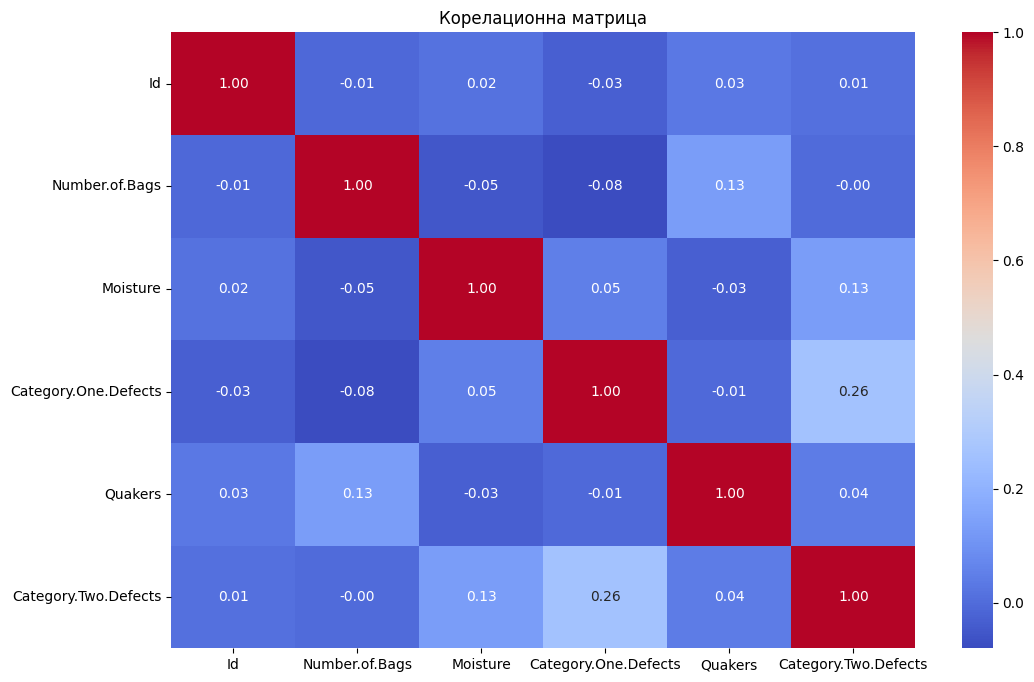

In [47]:
correlation_matrix = data_cleaned.corr(numeric_only= True)

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Корелационна матрица')
plt.show()

### One-hot encoding на категориалните променливи

Превръщаме категориалните променливи в числови чрез one-hot encoding, за да можем да ги използваме в моделите за машинно обучение.

In [24]:
data_encoded = pd.get_dummies(data_cleaned, columns=categorical_columns, drop_first=True)

Колоната 'Good.Quality.Coffee' е налична.


# Визуализациа на данните за качеството на кафето

### Визуализация на категориалните променливи (Speecies, Processing.Method, Colour)

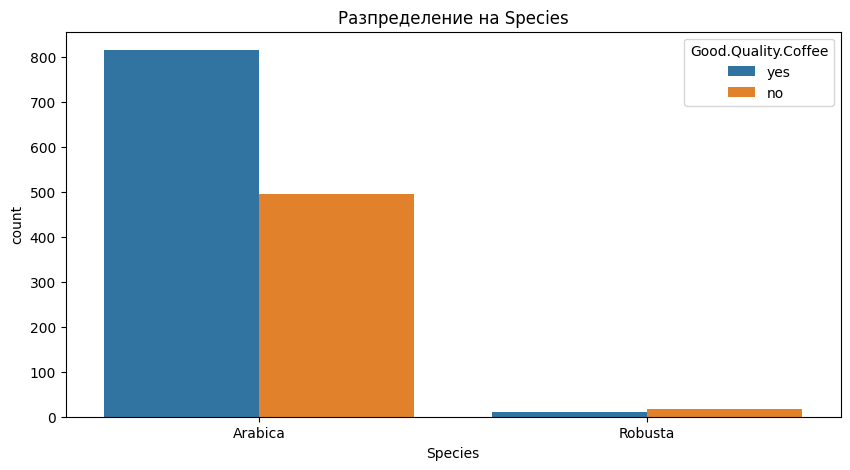

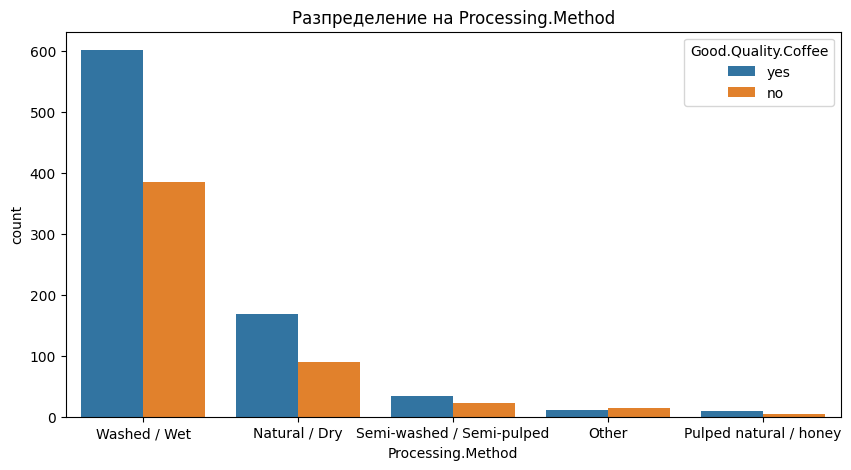

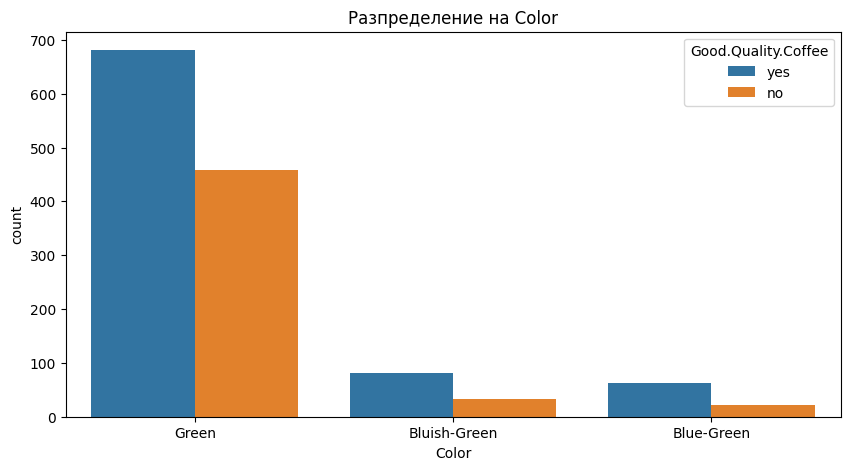

In [36]:
specific_categorical_columns = ['Species', 'Processing.Method', 'Color']

for column in specific_categorical_columns:
    plt.figure(figsize=(10, 5))
    sns.countplot(data=data_cleaned, x=column, hue='Good.Quality.Coffee')
    plt.title(f'Разпределение на {column}')
    plt.show()

От визуализирането на данните за вид, метод на обработка и цвят виждаме, че от записите в нашия набор от данни, доброто качество кафе най-често е Аrabica, Washed/Wet, Green.

### Визуализациа на съотношението между доброто качество кафе и нивото на влага

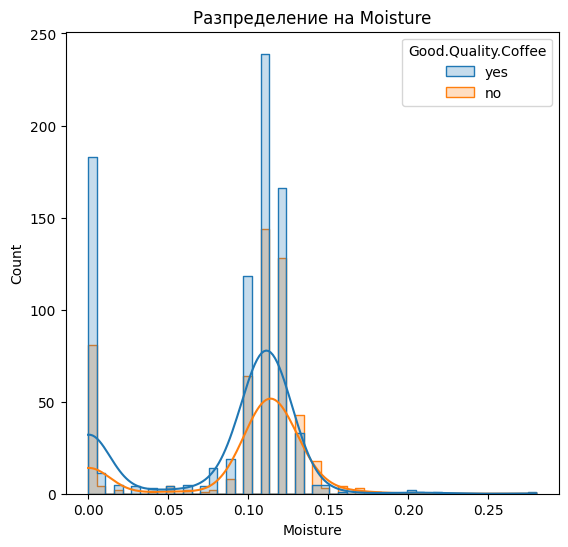

In [39]:
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(data=data_cleaned, x='Moisture', hue='Good.Quality.Coffee', kde=True, element='step')
plt.title('Разпределение на Moisture')

plt.show()

Виждаме, че в нашия набор от данни, високото качество кафе е обикновено или без съдържание на влага, или с такова между 0.09 и 0.14.

# Разделяне на данните на признаци (X) и целева променлива (y)

### Разделяме данните на входни признаци (X) и целева променлива (y), като целевата променлива е Good.Quality.Coffee.

In [26]:
X = data_encoded.drop(columns=['Id', 'Good.Quality.Coffee'])
y = data_encoded['Good.Quality.Coffee']

### Разделяне на данните на тренировъчен (80%) и валидационен (20%) набор

In [27]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Обучение и оценка на различни модели

Обучаваме различни модели за класификация като Логистична регресия, Дърво на решенията, Случаен горски масив и Метод на поддръжка на векторите.
Оценяваме точността на всеки модел на валидационния набор.

In [28]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=10000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC()
}

results = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    results[model_name] = accuracy

# Сравнение на резултатите

Сравняваме точността на различните модели и създаваме таблица с резултатите.

In [29]:
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['Accuracy'])
print(results_df)

                        Accuracy
Logistic Regression     0.708955
Decision Tree           0.652985
Random Forest           0.712687
Support Vector Machine  0.615672


# Заключение

Моделът Random Forest е постигнал най-висока точност при предсказване на качеството на кафето.

In [30]:
best_model_name = results_df['Accuracy'].idxmax()
best_model_accuracy = results_df['Accuracy'].max()
print(f"Най-добре представящият се модел е {best_model_name} с точност {best_model_accuracy:.2f}.")

Най-добре представящият се модел е Random Forest с точност 0.71.
